# Laboratório - Introdução ao Deep Learning

Neste laboratório vamos fazer algumas pequenas atividades para trabalhar
alguns dos conceitos ilustrados durante a apresentação.

## 1. Implementando um perceptron

O Perceptron é uma "formulação básica" para a implementação de redes neurais.
Implementá-lo é um passo inicial para o melhor entendimento de como 
funciona uma rede neural.


In [222]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display, HTML
plt.style.use('ggplot')

dados = pd.read_csv("data.csv",header=None,names=['x1','x2','y'])
X = dados[['x1','x2']].values
y = dados['y'].values

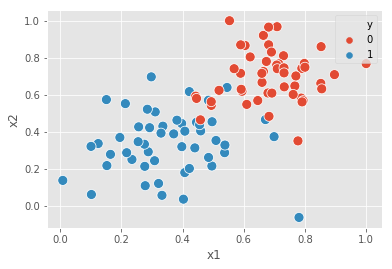

In [59]:
plot = sns.scatterplot(x='x1',y='x2',hue='y',data=dados,s=100)


Perceba que a fronteira de decisão é dada por:
$$W_0 x_1 + W_1 x_2 + b = 0 \therefore x_2 = - \frac{x_2 W_0}{W_1} - \frac{b}{W_1}$$

Por exemplo, faça $$W_0 = 0.1, W_1 = 0.6 , b = -0.4$$

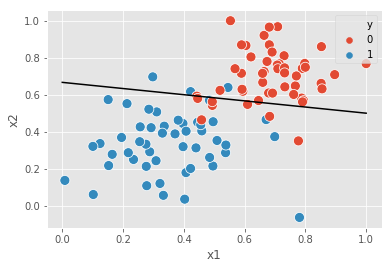

In [111]:
W0, W1, b = 0.1, 0.6, -0.4
x1 = np.linspace(0,1,100)
x2   = - vals*W0/W1 - b/W1
sns.scatterplot(x='x1',y='x2',hue='y',data=dados,s=100)
plt.plot(x1,x2,'k')

O código abaixo já está implementado. Você deve apenas implementar o update do Perceptron,
que está na **próxima célula**.

In [181]:
def stepFunction(t):
    if t >= 0:
        return 1
    return 0

def prediction(X, W, b):
    return stepFunction((np.matmul(X,W)+b)[0])

    
# Essa função irá aplicar a função de atualização do Perceptron
# assim, vai atualizar o valor dos pesos da fronteira de decisão.
def trainPerceptronAlgorithm(X, y, learn_rate = 0.01, num_epochs = 40):
    x_min, x_max = min(X.T[0]), max(X.T[0])
    y_min, y_max = min(X.T[1]), max(X.T[1])
    W = np.array(np.random.rand(2,1))
    b = np.random.rand(1)[0] + x_max
    boundary_lines = []
    for i in range(num_epochs):
        # In each epoch, we apply the perceptron step.
        W, b = perceptronStep(X, y, W, b, learn_rate)
        boundary_lines.append((-W[0]/W[1], -b/W[1]))
    return boundary_lines

### Você irá implementar essa função!
Relembre o pseudo-código que vimos para o Perceptron:
* A função prediction() irá prever o valor de cada y;
* Se a previsão foi 0, mas o correto era 1, atualize W[0] e W[1] somando valor de x1 e x2 vezes o learning rate. Para o viés (b) some o learning rate;
* Se a previsão foi 0, mas o correto era 1, atualize W[0] e W[1] subtraia valor de x1 e x2 vezes o learning rate. Para o viés (b) subtraia o learning rate;
* Se acertou a previsão, não precisa fazer nada. 

In [182]:
def perceptronStep(X, y, W, b, learn_rate = 0.01):
    for i in range(len(X)):
        y_hat = prediction(X[i],W,b)
        if y[i]-y_hat == 1:
            W[0] += X[i][0]*learn_rate
            W[1] += X[i][1]*learn_rate
            b += learn_rate
        elif y[i]-y_hat == -1:
            W[0] -= X[i][0]*learn_rate
            W[1] -= X[i][1]*learn_rate
            b -= learn_rate
    return W, b

Vamos visualizar o precesso de treinamento.

As linhas pretas são as fronteiras a medida que foi treinando.
A linha vermelha é a fronteira de decisão final após o treino. Parece fazer sentido?


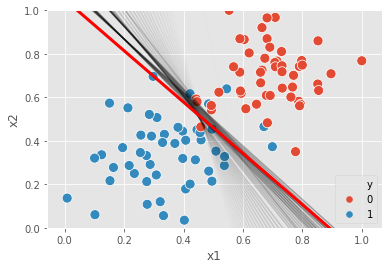

In [220]:
train = trainPerceptronAlgorithm(X,y)
x1 = np.linspace(0,1,100)
size = len(train)

for i,row in enumerate(train):
    A, C = row[0],row[1]
    x2   = x1*A + C 
    if i+1 == size:
        plt.plot(x1,x2,'r',alpha=1,linewidth=3)
    else: plt.plot(x1,x2,'k',alpha=i/(3*size))
    
sns.scatterplot(x='x1',y='x2',hue='y',data=dados,s=100)
plt.ylim(0,1)
print("As linhas pretas são as fronteiras a medida que foi treinando.")
print("A linha vermelha é a fronteira de decisão final após o treino. Parece fazer sentido?")

# 2. Convolutional Neural Networks

Vamos agora implementar uma Convolutional Neural Network. Os dados disponibilizados
são de imagens de agregados dos quais foram calculados um chamado índice de texture,
que é uma medida de rugosidade.

In [218]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.callbacks import ModelCheckpoint
from keras import backend

from sklearn.metrics import r2_score

Using TensorFlow backend.


### 2.1 Explorando os dados

Primeiro, vamos importar os dados e separar em um train and test set.

In [219]:
textureimages = np.load('textureimagequality10.npy') # Imagens
texturedata   = pd.read_csv('texturedataprepared.csv') # Textura

x_train = textureimages[:].astype('float32')/255 # Data normalization
y_train = texturedata['texture'][:].values

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

train_size, length, height, channels = x_train.shape

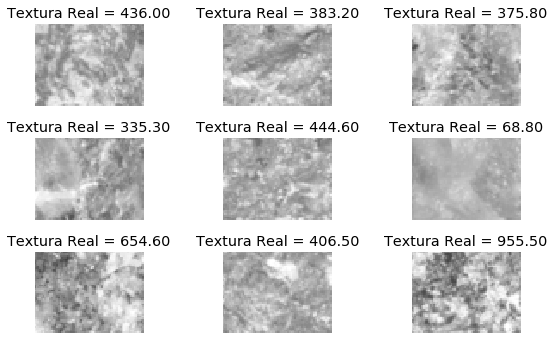

In [244]:
fig = plt.figure(figsize=(8,8))
for i in range(9):
    ax = fig.add_subplot(5, 3, i + 1, xticks=[], yticks=[])
    ax.imshow((x_test[i]))
    real = y_test[i]
    ax.set_title("Textura Real = {:.2f}".format(real,fontsize=25))
plt.tight_layout()

Distribuição do índice de textura.

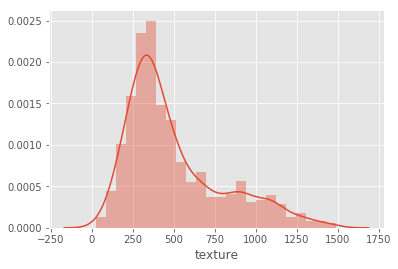

In [242]:
sns.distplot(texturedata['texture'])

### 2.2 Criando sua rede de convolução

Você deve implementar sua rede de convolução definindo cada uma das camadas! Abaixo está um exemplo
de rede de convolução. Esse abaixo é só um exemplo, você pode fazer com menos camada para agilizar
o treino e ainda obter um ótimo resultado.

----

![title](CNN-Architecture.png)

----

A função de R² será utilizada para avaliar o quão bem nosso modelo está prevendo a textura real.

In [250]:
def rsquared(y_true, y_pred):
    residuals     =  backend.sum(backend.square(y_true - y_pred)) 
    mean_residual = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return (1 - residuals/(mean_residual))

#### DEFINA SUA REDE DE CONVOLUÇÃO AQUI!
Você deve implementar sua rede de convolução na célula abaixo.Em seguida iremos
treinar o modelo e ver como está o desempenho. Comece com algo simples e vá
incrementando novas camadas para ir melhorando o R² gradativamente.

Consegue fazer um modelo que supere um R² de 0.95?

Além do R² iremos também avaliar o erro médio absoluto ($|V_{previsto} - V_{real}|$).

Qual o erro absoluto médio que seu modelo irá atingir?

In [247]:
model = Sequential()
model.add(Conv2D(filters=int(length/2), kernel_size=2, padding='same', activation='relu', 
                        input_shape=(length, height,channels)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=length*2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(1000, activation='relu')) # Added
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 64, 24)        408       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 32, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 32, 48)        4656      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 16, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 16, 96)        18528     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 8, 96)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 8, 96)          0         
__________

### 2.3 Treinando o modelo

In [253]:
# Compilando o modelo
model.compile(loss='mean_squared_error', optimizer='adam', 
                  metrics=[rsquared])

checkpointer = ModelCheckpoint(filepath='model.weights.cnn.hdf5', verbose=1, 
                               save_best_only=True)

Vamos primeiro treinar o modelo utilizando 10 epochs.

In [256]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=10,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 909 samples, validate on 228 samples
Epoch 1/10
 - 3s - loss: 13174.7608 - rsquared: 0.8452 - val_loss: 5308.0268 - val_rsquared: 0.9127

Epoch 00001: val_loss improved from 7362.19530 to 5308.02677, saving model to model.weights.cnn.hdf5
Epoch 2/10
 - 3s - loss: 11378.6246 - rsquared: 0.8647 - val_loss: 6851.6818 - val_rsquared: 0.9043

Epoch 00002: val_loss did not improve from 5308.02677
Epoch 3/10
 - 3s - loss: 6549.4447 - rsquared: 0.9210 - val_loss: 26414.6356 - val_rsquared: 0.5764

Epoch 00003: val_loss did not improve from 5308.02677
Epoch 4/10
 - 3s - loss: 7295.0634 - rsquared: 0.9075 - val_loss: 2973.9568 - val_rsquared: 0.9532

Epoch 00004: val_loss improved from 5308.02677 to 2973.95679, saving model to model.weights.cnn.hdf5
Epoch 5/10
 - 3s - loss: 5274.5625 - rsquared: 0.9367 - val_loss: 14718.8260 - val_rsquared: 0.7665

Epoch 00005: val_loss did not improve from 2973.95679
Epoch 6/10
 - 3s - loss: 6004.3739 - rsquared: 0.9298 - val_loss: 2833.2751 - val_rsqu

In [259]:
# Carrega o modelo com os melhores resultados
model.load_weights('model.weights.cnn.hdf5')

### 2.4 Avaliando os resultados

Vamos ver os valores de R² e Erro Médio Absoluto (MAE).

In [260]:
y_hat = model.predict(x_test) # Model prediction
r2_vanilla = r2_score(y_test,y_hat) # R-squared

y_test = y_test.reshape((y_test.shape[0],1)) # Adjust shape of array

residual = y_test - y_hat # Calculating the residuals from the real and the predicted
mae_vanilla      = np.mean((residual**2)**0.5) # Calculating the Mean Absolute Error

print("R-Squared = ", r2_vanilla)
print("MAE       = ", mae_vanilla)

R-Squared =  0.9702902206011805
MAE       =  38.39327497381913


Você conseguiu passar dos 0.95?

Vamos dar uma olhada na distribuição dos valores previstos vs. os reais. 

Test set average   =  495.8122807017544
Prediction average =  489.8145


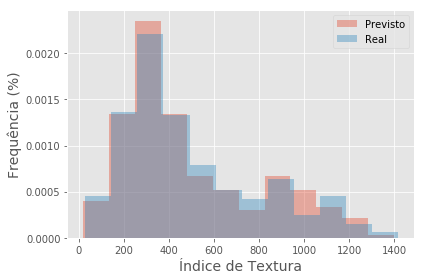

In [265]:
# Visualizing the prediction distribution and the test set distribution
sns.distplot(y_hat,kde=False,norm_hist=True, label='Previsto')
sns.distplot(y_test,kde=False,norm_hist=True,label='Real')
plt.xlabel("Índice de Textura",size=14)
plt.ylabel("Frequência (%)",size=14)
plt.legend()
print("Test set average   = ",np.average(y_test))
print("Prediction average = ",np.average(y_hat))
plt.tight_layout()

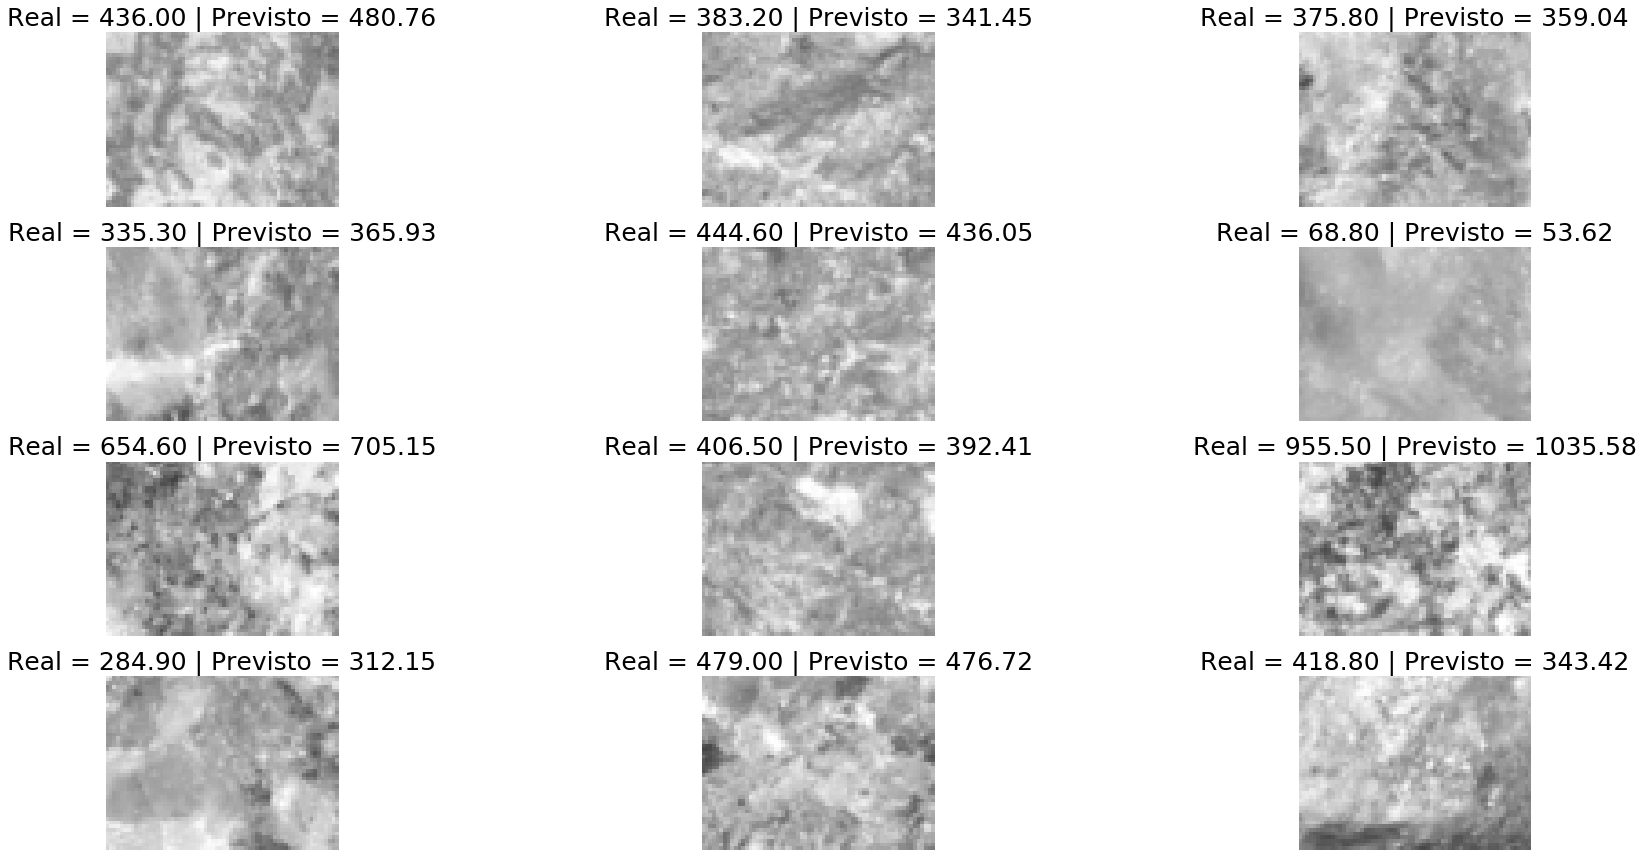

In [268]:
# Visualizando os resultados

fig = plt.figure(figsize=(25,15))
for i in range(12):
    ax = fig.add_subplot(5, 3, i + 1, xticks=[], yticks=[])
    ax.imshow((x_test[i]))
    real = y_test[i]
    predicted = y_hat[i]
    ax.set_title("Real = {:.2f} | Previsto = {:.2f}".format(real[0],predicted[0]),fontsize=25)
plt.tight_layout()

# FIM.